<a href="https://colab.research.google.com/github/velasoka-repo/EVA4/blob/master/Session-5/EVA4_S5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Github Link](https://github.com/velasoka-repo/EVA4/blob/master/Session-5/EVA4_S5_2.ipynb)

#Target:
1. Basic Transforms (ToTensor, Normalize)
2. Basic Data Loader (Train & Test)
3. **Improving Basic CNN Model & trying to reducing parameter < 10K**
4. Adding Batch Normalization to increase Test Accuracy
5. Adding Dropout to reduce gap between Train & Test Accuracy 
6. Basic Training  & Test Loop

#Results:
1. Parameters: 9.95K
2. Best Training Accuracy: 99.04% 
3. Best Test Accuracy: 99.26%
4. Epochs: 15

# *Analysis: BatchNorm after ReLU & Dropout (Best Model)
1. Achieved Target Parameters `9.95K` which is less than `10K`
2. Train Accuracy is increasing for each epoch
3. Test Accuracy is not stable (Accuracy is slightly going UP & DOWN)
4. Seeing overfitting (Train: `99.04%`, Test: `99.20%`) 
5. Batch Normalized increased Test Accuracy a bit
6. Dropout reduces gap between Train & Test Accuracy (Reduced Overfitting)

#Analysis: BatchNorm after ReLU
1. Very close to 10K parameter
2. Train Accuracy is increasing for each epoch
3. Test Accuracy is not stable (Accuracy is slightly going UP & DOWN)
4. Seeing overfitting (Train: `99.98%`, Test: `99.17%`)
5. Batch Normalized increased Test Accuracy a bit

#Analysis: BatchNorm before ReLU
1. Very close to 10K parameter
2. Train Accuracy is increasing for each epoch
3. Test Accuracy is not stable (Accuracy is slightly going UP & DOWN)
4. Seeing overfitting (Train: `99.78%`, Test: `99.19%`) 
5. Batch Normalized increased Test Accuracy a bit

- - -
#EVA4-S5_1 Model Analysis:
1. Simple Model with lots of parameter (`Previous Model Parameter: 1.6M`)
2. Train Accuracy is increasing for each epoch
3. Test Accuracy is not stable (Accuracy is going UP & DOWN)
4. Seeing overfitting (Train: `99.95%`, Test: `99.08%`)

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
from torchsummary import summary

%matplotlib inline
import matplotlib.pyplot as plt

## Data Transformations

Applying following three transformation

1.   Compose - group multiple transform into sequential transform
2.   ToTensor - Convert numpy | PILImage to tensor and convert range between 0-1 
`(i.e) array/255`
3. Normalize - input data(train & test) is normalized besed on `mean` & `std` 
`(i.e) (i'th value - mean)/std => final i'th range becomes (-1, 1)`

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Test Phase transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [8]:
SEED = 6

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model with BatchNorm, Dropout `after` ReLU

* if I add Dropout2d at each black, Train & Test Accuracy is not crossing 97% & 98%. below are details for the run

```
EPOCH: 15
Loss=0.11638030409812927 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:09<00:00, 49.85it/s]
Test set: Average loss: 0.0388, Accuracy: 9870/10000 (98.70%)
```
* I added `Dropout` before Transition block

In [0]:
class Net3(nn.Module):
    def __init__(self, fm_size, dropout_value=0.25):
        super(Net3, self).__init__()
        self.fm_size = fm_size
        self.num_classes = 10
        self.dropout_value = dropout_value
        self.dropout = nn.Dropout2d(self.dropout_value)
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
            # nn.Dropout2d(self.dropout_value)
        ) # output_size = 26

        # self.fm_size *=2
        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
            # nn.Dropout2d(self.dropout_value)
        ) # output_size = 24

        # self.fm_size *=2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size*1.5), kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size*1.5)),
            # nn.Dropout2d(self.dropout_value)
        ) # output_size = 22
        
        self.fm_size = int(self.fm_size*1.5)
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size/1.5), kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size/1.5)),
            # nn.Dropout2d(self.dropout_value)
        ) # output_size = 11

        self.fm_size = int(self.fm_size/1.5)
        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
            # nn.Dropout2d(self.dropout_value)
        ) # output_size = 9

        # self.fm_size *=2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size*1.5), kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size*1.5)),
            # nn.Dropout2d(self.dropout_value)
        ) # output_size = 7

        self.fm_size = int(self.fm_size*1.5)
        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.num_classes, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.num_classes),
            # nn.Dropout2d(self.dropout_value)
        ) # output_size = 7

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=self.num_classes, out_channels=self.num_classes, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Available device: {device}")
model = Net3(10).to(device)
summary(model, input_size=(1, 28, 28))

Available device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]             900
              ReLU-5           [-1, 10, 24, 24]               0
       BatchNorm2d-6           [-1, 10, 24, 24]              20
            Conv2d-7           [-1, 15, 22, 22]           1,350
              ReLU-8           [-1, 15, 22, 22]               0
       BatchNorm2d-9           [-1, 15, 22, 22]              30
        Dropout2d-10           [-1, 15, 22, 22]               0
        MaxPool2d-11           [-1, 15, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             150
             ReLU-13           [-1, 10, 11, 11]               0
      BatchNorm2

# Training and Testing

In [0]:
def train(model, device, train_loader, optimizer, epoch, train_repo):
  train_losses, train_acc = train_repo
  model.train()
  pbar = tqdm(iterable=train_loader, total=len(train_loader), position=0)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_repo):
    test_losses, test_acc = test_repo
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Draw Accuracy Graph

In [0]:
def draw_accuracy(train_repo, test_repo):
  train_losses, train_acc = train_repo
  test_losses, test_acc = test_repo
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc)
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")

# Train and test our model for `Net3`
* It has BatchNorm, Dropout `after` ReLU

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.09269151836633682 Batch_id=468 Accuracy=93.24: 100%|██████████| 469/469 [00:09<00:00, 50.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0569, Accuracy: 9827/10000 (98.27%)

EPOCH: 2


Loss=0.053708553314208984 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:09<00:00, 49.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 9859/10000 (98.59%)

EPOCH: 3


Loss=0.04817093908786774 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:09<00:00, 49.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9899/10000 (98.99%)

EPOCH: 4


Loss=0.09492210298776627 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:09<00:00, 50.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9885/10000 (98.85%)

EPOCH: 5


Loss=0.08292759954929352 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:09<00:00, 50.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9898/10000 (98.98%)

EPOCH: 6


Loss=0.06739014387130737 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:09<00:00, 50.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.018978485837578773 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:09<00:00, 50.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9897/10000 (98.97%)

EPOCH: 8


Loss=0.0763549730181694 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:09<00:00, 50.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9910/10000 (99.10%)

EPOCH: 9


Loss=0.05793109908699989 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:09<00:00, 50.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9909/10000 (99.09%)

EPOCH: 10


Loss=0.017074093222618103 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:09<00:00, 49.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Loss=0.15879856050014496 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:09<00:00, 50.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9902/10000 (99.02%)

EPOCH: 12


Loss=0.020281493663787842 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:09<00:00, 49.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


Loss=0.05504895746707916 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:09<00:00, 49.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9908/10000 (99.08%)

EPOCH: 14


Loss=0.0058824121952056885 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:09<00:00, 50.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9902/10000 (99.02%)

EPOCH: 15


Loss=0.07158298045396805 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:09<00:00, 50.35it/s]



Test set: Average loss: 0.0261, Accuracy: 9920/10000 (99.20%)

---------------------------------------------------------------------------


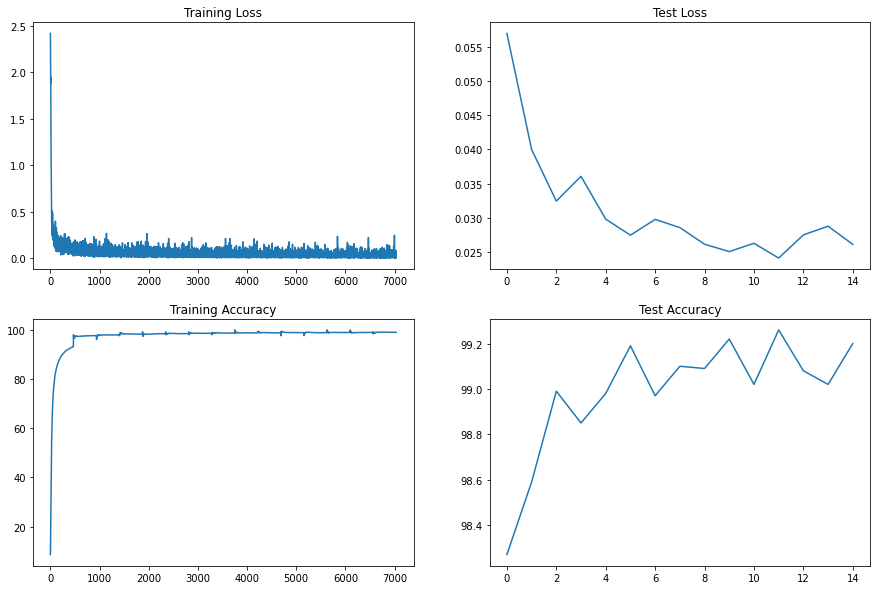

In [0]:
model =  Net3(10).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
test_repo = ([], [])
train_repo = ([], [])
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, train_repo)
    test(model, device, test_loader, test_repo)

print("-"*75)
draw_accuracy(train_repo, test_repo)

# - - - Tried Various Other Changes in the Model - - -

### The model with BatchNorm `after` ReLU

In [0]:
class Net1(nn.Module):
    def __init__(self, fm_size):
        super(Net1, self).__init__()
        self.fm_size = fm_size
        self.num_classes = 10
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size)
        ) # output_size = 26

        # self.fm_size *=2
        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size)
        ) # output_size = 24

        # self.fm_size *=2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size*2, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size*2)
        ) # output_size = 22
        
        self.fm_size *=2
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size//2, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size//2)
        ) # output_size = 11

        self.fm_size //=2
        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size)
        ) # output_size = 9

        # self.fm_size *=2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size*2, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size*2)
        ) # output_size = 7

        self.fm_size *=2
        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.num_classes, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.num_classes)
        ) # output_size = 7

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=self.num_classes, out_channels=self.num_classes, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### The model with BatchNorm `before` ReLU

In [0]:
class Net2(nn.Module):
    def __init__(self, fm_size):
        super(Net2, self).__init__()
        self.fm_size = fm_size
        self.num_classes = 10
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(num_features=self.fm_size),
            nn.ReLU()
        ) # output_size = 26

        # self.fm_size *=2
        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(num_features=self.fm_size),
            nn.ReLU()
        ) # output_size = 24

        # self.fm_size *=2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size*2, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(num_features=self.fm_size*2),
            nn.ReLU()
        ) # output_size = 22
        
        self.fm_size *=2
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size//2, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(num_features=self.fm_size//2),
            nn.ReLU()
        ) # output_size = 11

        self.fm_size //=2
        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(num_features=self.fm_size),
            nn.ReLU()
        ) # output_size = 9

        # self.fm_size *=2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size*2, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(num_features=self.fm_size*2),
            nn.ReLU()
        ) # output_size = 7

        self.fm_size *=2
        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.num_classes, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(num_features=self.num_classes),
            nn.ReLU()
        ) # output_size = 7

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=self.num_classes, out_channels=self.num_classes, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### Train and test our model for `Net1`
* It has BatchNorm `after` ReLU

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.017830336466431618 Batch_id=468 Accuracy=95.91: 100%|██████████| 469/469 [00:09<00:00, 47.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9833/10000 (98.33%)

EPOCH: 2


Loss=0.0991131141781807 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:09<00:00, 47.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9898/10000 (98.98%)

EPOCH: 3


Loss=0.009516234509646893 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:09<00:00, 48.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9898/10000 (98.98%)

EPOCH: 4


Loss=0.0016625424614176154 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:09<00:00, 49.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9906/10000 (99.06%)

EPOCH: 5


Loss=0.002727791666984558 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:09<00:00, 49.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9913/10000 (99.13%)

EPOCH: 6


Loss=0.016423368826508522 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:09<00:00, 49.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.009246657602488995 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:09<00:00, 49.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9909/10000 (99.09%)

EPOCH: 8


Loss=0.025392383337020874 Batch_id=468 Accuracy=99.69: 100%|██████████| 469/469 [00:09<00:00, 50.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.015655672177672386 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:09<00:00, 49.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9927/10000 (99.27%)

EPOCH: 10


Loss=0.001767019391991198 Batch_id=468 Accuracy=99.79: 100%|██████████| 469/469 [00:09<00:00, 49.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9912/10000 (99.12%)

EPOCH: 11


Loss=0.0011039773235097528 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:09<00:00, 48.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9917/10000 (99.17%)

EPOCH: 12


Loss=0.004009286407381296 Batch_id=468 Accuracy=99.92: 100%|██████████| 469/469 [00:09<00:00, 49.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9905/10000 (99.05%)

EPOCH: 13


Loss=0.007543608546257019 Batch_id=468 Accuracy=99.94: 100%|██████████| 469/469 [00:09<00:00, 48.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9914/10000 (99.14%)

EPOCH: 14


Loss=0.0029406051617115736 Batch_id=468 Accuracy=99.96: 100%|██████████| 469/469 [00:09<00:00, 48.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9928/10000 (99.28%)

EPOCH: 15


Loss=0.00019635756325442344 Batch_id=468 Accuracy=99.98: 100%|██████████| 469/469 [00:09<00:00, 49.36it/s]



Test set: Average loss: 0.0267, Accuracy: 9917/10000 (99.17%)


		Net1: BatchNorm applied after ReLU
---------------------------------------------------------------------------


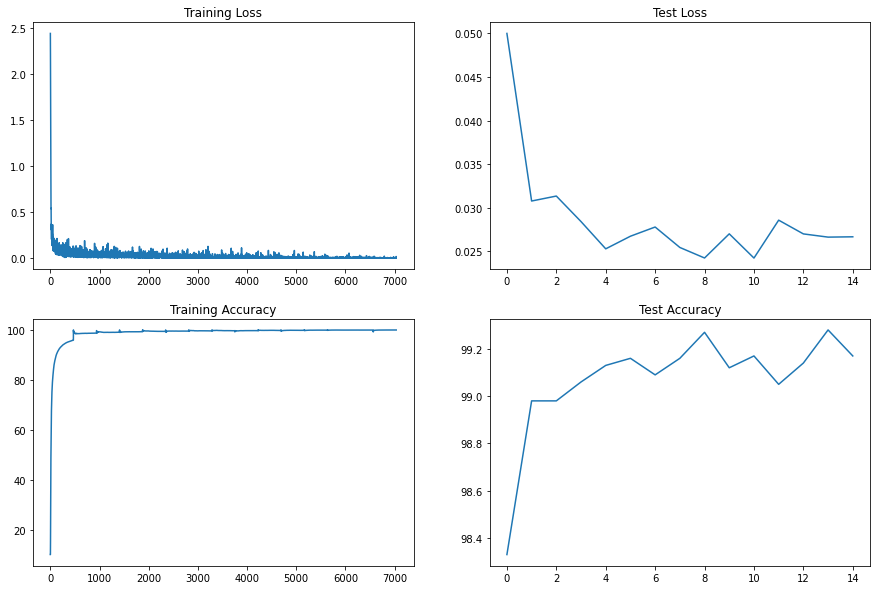

In [15]:
model =  Net1(16).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
test_repo = ([], [])
train_repo = ([], [])
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, train_repo)
    test(model, device, test_loader, test_repo)

print("\n\t\tNet1: BatchNorm applied after ReLU")
print("-"*75)
draw_accuracy(train_repo, test_repo)

### Train and test our model for `Net2`
* It has BatchNorm `before` ReLU

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.11053498834371567 Batch_id=468 Accuracy=94.92: 100%|██████████| 469/469 [00:09<00:00, 47.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0573, Accuracy: 9832/10000 (98.32%)

EPOCH: 2


Loss=0.058121923357248306 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:09<00:00, 49.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Accuracy: 9863/10000 (98.63%)

EPOCH: 3


Loss=0.015821749344468117 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:09<00:00, 49.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9878/10000 (98.78%)

EPOCH: 4


Loss=0.03561185672879219 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:09<00:00, 49.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9878/10000 (98.78%)

EPOCH: 5


Loss=0.0032931168098002672 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:09<00:00, 49.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9902/10000 (99.02%)

EPOCH: 6


Loss=0.009673436172306538 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:09<00:00, 49.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9909/10000 (99.09%)

EPOCH: 7


Loss=0.005084410309791565 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:09<00:00, 49.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9913/10000 (99.13%)

EPOCH: 8


Loss=0.03364004194736481 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:09<00:00, 48.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9909/10000 (99.09%)

EPOCH: 9


Loss=0.014269049279391766 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:09<00:00, 48.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.010257323272526264 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:09<00:00, 48.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9916/10000 (99.16%)

EPOCH: 11


Loss=0.07828719168901443 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:09<00:00, 48.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9911/10000 (99.11%)

EPOCH: 12


Loss=0.013005673885345459 Batch_id=468 Accuracy=99.63: 100%|██████████| 469/469 [00:09<00:00, 49.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9925/10000 (99.25%)

EPOCH: 13


Loss=0.02484826184809208 Batch_id=468 Accuracy=99.70: 100%|██████████| 469/469 [00:09<00:00, 48.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9920/10000 (99.20%)

EPOCH: 14


Loss=0.00037079057074151933 Batch_id=468 Accuracy=99.76: 100%|██████████| 469/469 [00:09<00:00, 47.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9924/10000 (99.24%)

EPOCH: 15


Loss=0.002601057291030884 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:10<00:00, 46.56it/s]



Test set: Average loss: 0.0253, Accuracy: 9919/10000 (99.19%)

---------------------------------------------------------------------------


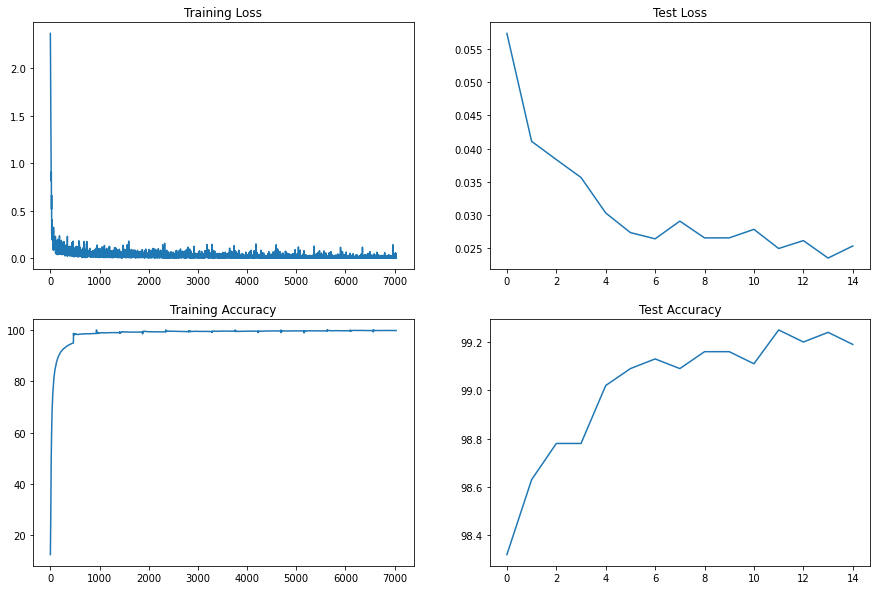

In [16]:
model =  Net2(10).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
test_repo = ([], [])
train_repo = ([], [])
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, train_repo)
    test(model, device, test_loader, test_repo)

print("-"*75)
draw_accuracy(train_repo, test_repo)